In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim).to(device)

In [5]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2,inplace=True)
    )

In [6]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

In [7]:
# Set the parameter
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cpu'

## changing (above) device = "cuda" will enable training on GPUs

In [8]:
# Creating the generator and the discriminator
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    bch = get_noise(num_images, z_dim, device=device)

    generator_images = gen(bch)

    # for fake image - step 2
    y_pred_fake = disc(generator_images.detach())
    
    loss1 = criterion(y_pred_fake, torch.zeros_like(y_pred_fake))
    
    #for real image - step 3
    y_pred_real = disc(real)
    
    loss2 = criterion(y_pred_real, torch.ones_like(y_pred_real))
    
    disc_loss = (loss1 + loss2)/2

    return disc_loss

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    
    noise_vecs =  get_noise(num_images, z_dim, device=device)

    generator_images = gen(noise_vecs)

    y_pred_fake = disc(generator_images)
    
    loss1 = criterion(y_pred_fake, torch.ones_like(y_pred_fake))

    gen_loss = loss1

    return gen_loss

In [14]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        
        gen_loss.backward(retain_graph=True)
        
        gen_opt.step()

  0%|          | 0/469 [00:00<?, ?it/s]

## Inference:

In [12]:
noise_vecs =  get_noise(2, z_dim, device=device)

generator_images = gen(noise_vecs)

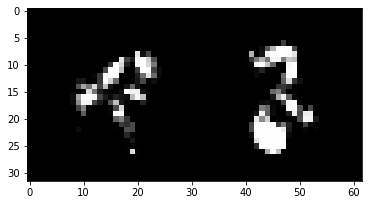

In [13]:
show_tensor_images(generator_images)